**Package Installation**

The following commands install essential Python packages needed for data analysis, visualization, machine learning, and computer vision. 

In [1]:
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install opencv-python-headless
!pip install scikit-learn
!pip install tensorflow

**Import Necessary Modules**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import os
import glob
import shutil
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, BatchNormalization, Dense, RandomFlip, RandomTranslation, RandomRotation, GlobalAveragePooling2D, Input, RandomZoom, Rescaling, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

**Copying Image Files from Source to Destination**



In [3]:
def copy(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir)

copy(r'/kaggle/input/brain-tumor-mri-dataset/Training', r'/kaggle/input/brain-tumor-mri-dataset/Training')
copy(r'/kaggle/input/brain-tumor-mri-dataset/Testing', r'/kaggle/input/brain-tumor-mri-dataset/Testing')

**Loading the Dataset**

In [4]:
#  Getting all the dataset:

train, validation = image_dataset_from_directory(directory = r"/kaggle/input/brain-tumor-mri-dataset/Training", batch_size=32, image_size=(256, 256), validation_split=0.2, subset='both', seed=234)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.


**Visualizing the Images**

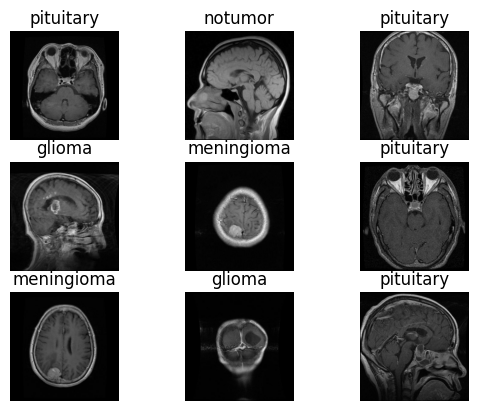

(32, 256, 256, 3)
(32,)


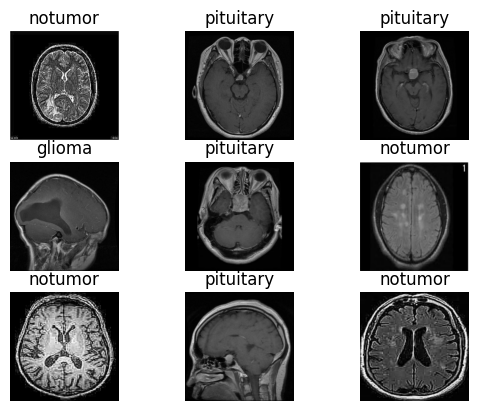

(32, 256, 256, 3)
(32,)


In [5]:

def visual(image, class_name, number):
    for i in range(number):
        plt.subplot(int(np.sqrt(number)), int(np.sqrt(number)), i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')
    plt.show()
number = 9
class_name = train.class_names

for image, label in train.take(1):
    visual(image, class_name, number)
    img_shape = image.shape
    lab_shape = label.shape

print(img_shape)
print(lab_shape)

for image, label in validation.take(1):
    visual(image, class_name, number)
    img_shape = image.shape
    lab_shape = label.shape

print(img_shape)
print(lab_shape)

**Counting and Visualizing Class Distribution**

['glioma', 'meningioma', 'notumor', 'pituitary']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


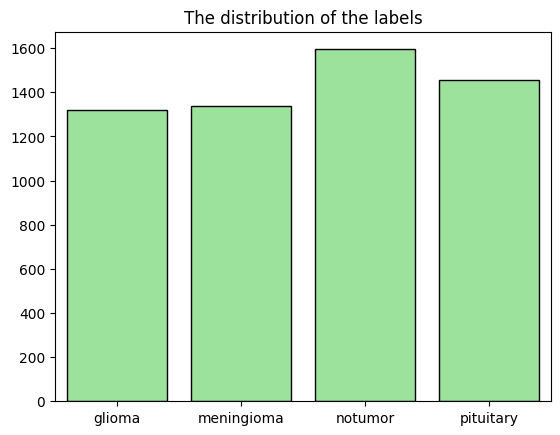

1321
1339
1595
1457


In [6]:


def counter(path):
    c = 0
    for p in os.scandir(path):
        if p.is_file():
            c += 1
    return c

print(class_name)

glioma_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/glioma'
meningioma_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'
notumor_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/notumor'
pituitary_path = r'/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'

glioma_count = counter(glioma_path)
meningioma_count = counter(meningioma_path)
notumor_count = counter(notumor_path)
pituitary_count = counter(pituitary_path)

sn.barplot(x = class_name, y=[glioma_count, meningioma_count, notumor_count, pituitary_count], color='lightgreen', edgecolor='black')
plt.title("The distribution of the labels")
plt.show()

print(glioma_count)
print(meningioma_count)
print(notumor_count)
print(pituitary_count)

**Model Architecture for Brain Tumor Classification**

In [7]:


model = Sequential([
    Input(shape=(256, 256, 3), batch_size=32),
    
    Rescaling(1./255.),
    RandomFlip('horizontal'),
    RandomRotation(0.2),
   
    
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', name='Conv2D_1'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_3'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_4'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    #GlobalAveragePooling2D(),
    Flatten(),
    
    Dense(units=32, activation='relu'),
    #BatchNormalization(),
    Dense(units=64, activation='relu'),
    #Dropout(0.4),
    Dense(units=128, activation='relu'),
    
    #BatchNormalization(),
    Dense(units=256, activation='relu'),
    #BatchNormalization(),
    Dense(units=128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.4),
    Dense(units=len(class_name), activation='softmax')
    
])

**Callbacks for Model Training**

In [8]:
    ES = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
    MP = ModelCheckpoint(filepath='Best_model.keras', monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
    RP = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

****

**Model Compilation and Training for Brain Tumor Classification**

In [9]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history = model.fit(train, validation_data=validation, epochs=25, callbacks=[ES, MP, RP])

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6196 - loss: 0.8923
Epoch 1: val_accuracy improved from -inf to 0.40193, saving model to Best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.6201 - loss: 0.8914 - val_accuracy: 0.4019 - val_loss: 2.0130 - learning_rate: 0.0010
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7907 - loss: 0.5545
Epoch 2: val_accuracy improved from 0.40193 to 0.75219, saving model to Best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7908 - loss: 0.5545 - val_accuracy: 0.7522 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8327 - loss: 0.4538
Epoch 3: val_accuracy improved from 0.75219 to 0.82925, saving model to Best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8326 - loss: 0.4538 - val_accuracy: 0.8292 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 65m

**Model Performance Visualization**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

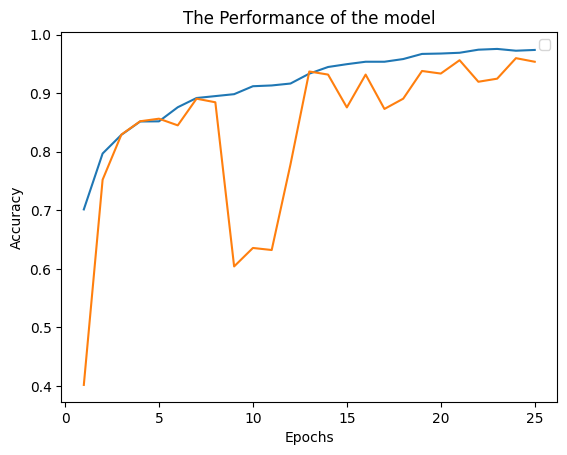

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

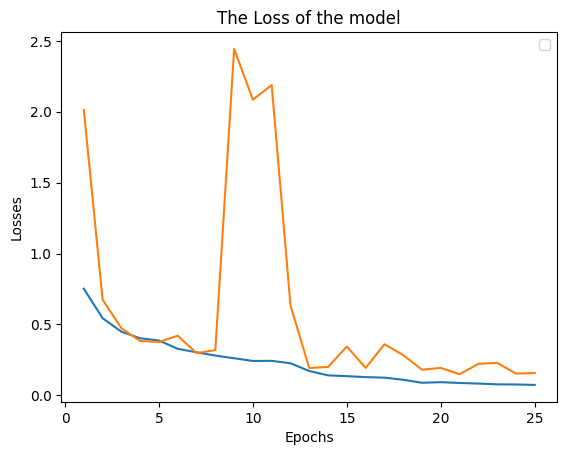

In [10]:

sn.lineplot(x = np.arange(1, len(history.history['accuracy'])+1), y = history.history['accuracy'])
sn.lineplot(x = np.arange(1, len(history.history['val_accuracy'])+1), y = history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("The Performance of the model")
plt.legend()
plt.show()

sn.lineplot(x = np.arange(1, len(history.history['loss'])+1), y = history.history['loss'])
sn.lineplot(x = np.arange(1, len(history.history['val_loss'])+1), y = history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title("The Loss of the model")
plt.legend()
plt.show()

**Model Evaluation on Validation Dataset**

In [11]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation)

# Print the accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9668 - loss: 0.1196
Validation Accuracy: 0.96


**Plotting the Training and Validation Accuracy**

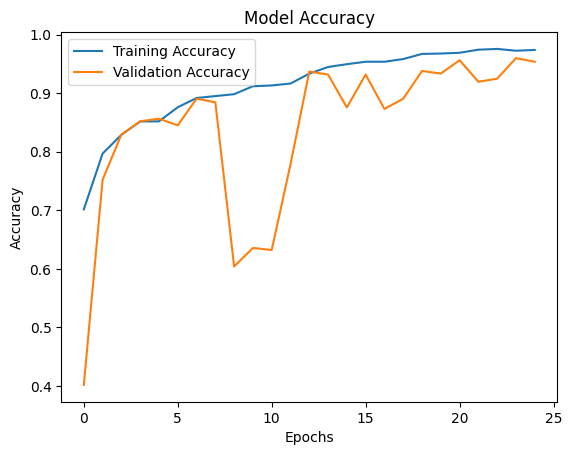

In [12]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


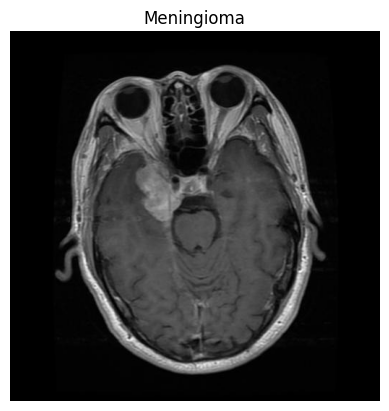

In [14]:
from tensorflow.keras.models import load_model

predictor = load_model(r'/kaggle/working/Best_model.keras')

image = r'/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/m (104).jpg'

image = cv2.imread(image)

image1 = cv2.resize(image, (256, 256))
batch_size = 32
batch = np.stack([image1] * batch_size, axis=0)

result = model.predict(batch)
result = (np.argmax(result, axis=1))[0]

label = ""

if result == 0:
    label += "Glioma"
elif result == 1:
    label += "Meningioma"
elif result == 2:
    label += "No Tumor"
elif result == 3:
    label += "Pituitary"

plt.imshow(image)
plt.title(label)
plt.axis('off')
plt.show()